In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import missingno as mnso
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 서울시 행정구역 경계를 GeoJSON으로 표현한 파일
geo_path = 'data/seoul_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

In [3]:
# matplotlib 차트의 기본 설정
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'NanumGothic'

In [4]:
# 대여소 정보
rental = pd.read_csv('data/대여소 정보.csv')
rental.head()

,대여소 번호,보관소(대여소)명,자치구,상세주소,위도,경도,설치시기,LCD,QR,운영 방식
0,1695,월계미륭아파트 정문,노원구,노원구 월계동 14,37.623417,127.066933,2020-06-17,NaN,10.0,QR
1,2301,현대고등학교 건너편,강남구,서울특별시 강남구 압구정로 134,37.524071,127.021790,2017-06-13,10.0,NaN,LCD
2,2302,교보타워 버스정류장(신논현역 3번출구 후면),강남구,서울특별시 강남구 봉은사로 지하 102,37.505581,127.024277,2017-06-13,10.0,NaN,LCD
3,2303,논현역 7번출구,강남구,서울특별시 강남구 학동로 지하 102,37.511517,127.021477,2017-06-13,15.0,NaN,LCD
4,2304,신영 ROYAL PALACE 앞,강남구,서울특별시 강남구 언주로 626,37.512527,127.035835,2017-06-13,10.0,NaN,LCD


In [5]:
rental.shape

(2083, 10)

- 행 : 2083
- 열 : 10


## 결측치 시각화

<AxesSubplot:>

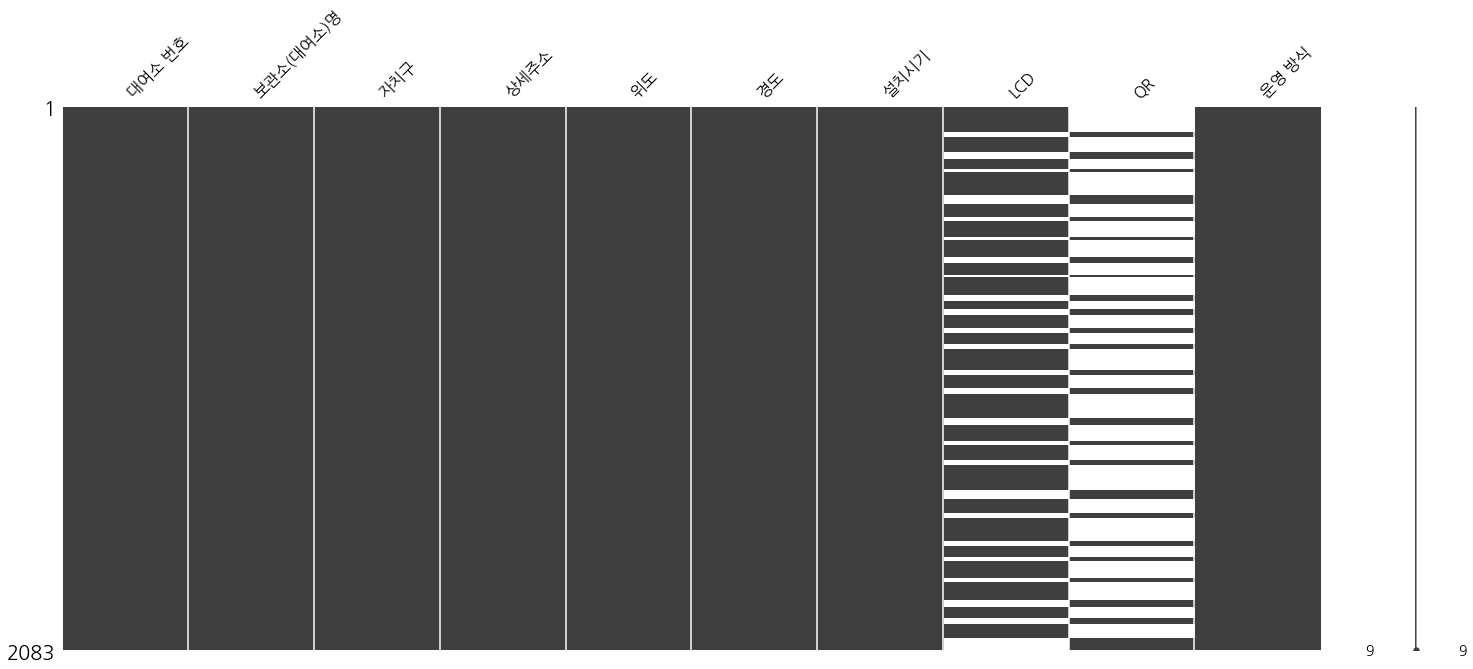

In [6]:
import missingno as msno
msno.matrix(rental)

- 하얀 부분이 결측치
- LCD와 QR이 결측치가 있음


# 따릉이 대여소 위치 시각화

In [7]:
bike_map = folium.Map(location=[rental['위도'].mean(), rental['경도'].mean()], zoom_start=10.8, tiles='CartoDB positron')
for i, row in rental.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=1,
        fill=True,
    ).add_to(bike_map)
bike_map

## 대여소 밀집도(히트맵)

In [8]:
# 히트맵
bike_map = folium.Map(location=[rental['위도'].mean(), rental['경도'].mean()], zoom_start=10.8, tiles='CartoDB positron')
plugins.HeatMap(rental[['위도', '경도']].values.tolist(), radius=10, blur=5).add_to(bike_map)
plugins.Fullscreen(positions='topright').add_to(bike_map)
bike_map

# 지역구 중심으로 살펴보기

## - 대여소 개수 살펴보기

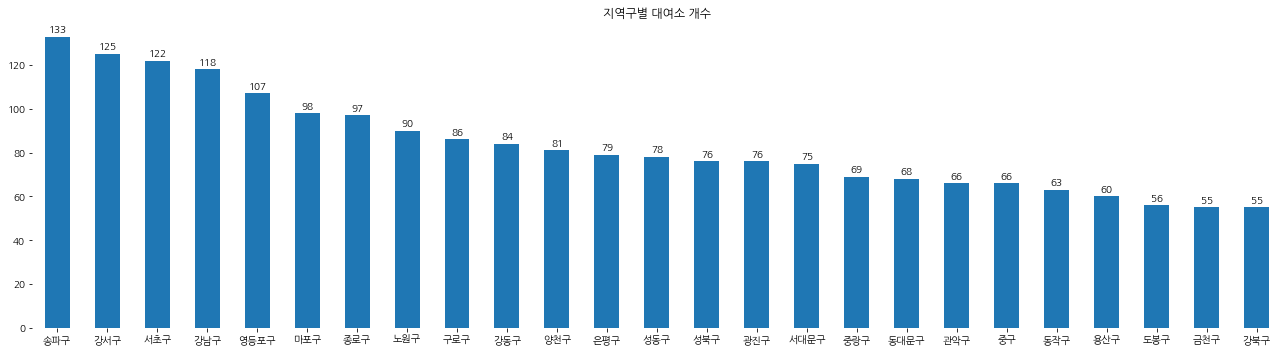

In [9]:
have_bikes = rental.groupby('자치구').size()
have_bikes.sort_values(ascending=False, inplace=True)

ax = have_bikes.plot(kind='bar', figsize=(18, 5), rot=0, title="지역구별 대여소 개수")
for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%d"%(height), (left+width/2, height+2), ha='center')
plt.box(False)
plt.xlabel('')
plt.tight_layout()
plt.show()

- 가장 많은 곳 : 송파구(133개)
- 가장 적은 곳 : 금천구(55개), 강북구(55개)
- 약 3배 가량 차이


## - 지역별 대여소 개수

In [10]:
bike_map = folium.Map(location=[rental['위도'].mean(), rental['경도'].mean()], zoom_start=11, tiles='cartodbpositron')
folium.Choropleth(geo_data=geo_str,
                  data=have_bikes,
                  key_on='feature.properties.SIG_KOR_NM', 
                  fill_color='Blues').add_to(bike_map)
bike_map

- 색이 진할수록 해당 지역에 대여소 개수가 많다는 의미
- 강남 3구(송파, 서초, 강남)와 한강 서쪽 지역(강서, 영등포, 마포)이 대여소가 많음

## - 지역별 대여소당 평균 거치대수 비교

### 1) LCD 거치대 수 분포

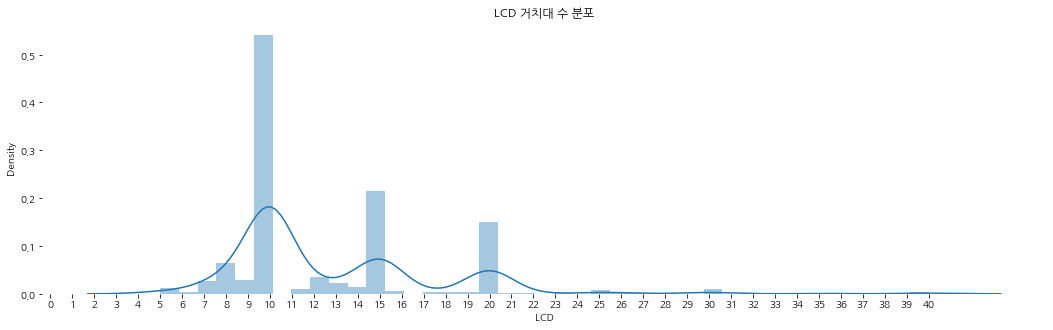

In [11]:
plt.figure(figsize=(18, 5))
sns.distplot(rental['LCD'])
plt.title("LCD 거치대 수 분포")
plt.xticks(range(0, 41))
plt.box(False)
plt.show()

- 일반적으로 10개, 조금더 많은 곳은 15개, 20개가 대표적


### 2) QR 거치대 수 분포

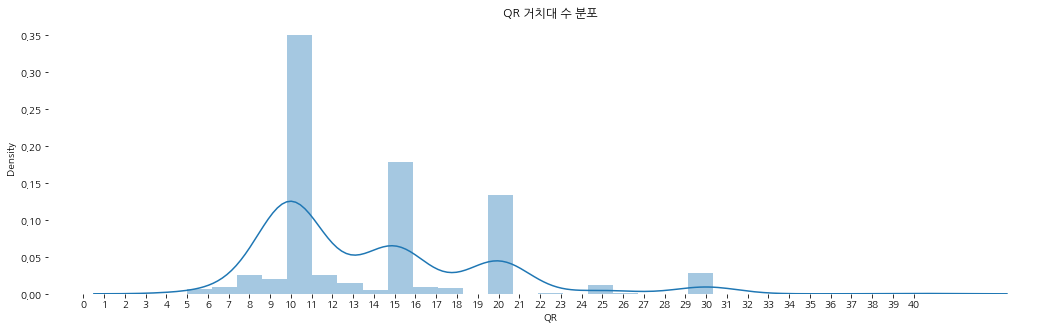

In [12]:
plt.figure(figsize=(18, 5))
sns.distplot(rental['QR'])
plt.title("QR 거치대 수 분포")
plt.xticks(range(0, 41))
plt.box(False)
plt.show()

- 일반적으로 11개, 조금더 많은 곳은 15~16개, 20개가 대표적


### 3) 거치대수(LCD+QR) 분포

### * 결측치 채우기

In [13]:
rental=rental.fillna(0)
rental.head()

,대여소 번호,보관소(대여소)명,자치구,상세주소,위도,경도,설치시기,LCD,QR,운영 방식
0,1695,월계미륭아파트 정문,노원구,노원구 월계동 14,37.623417,127.066933,2020-06-17,0.0,10.0,QR
1,2301,현대고등학교 건너편,강남구,서울특별시 강남구 압구정로 134,37.524071,127.021790,2017-06-13,10.0,0.0,LCD
2,2302,교보타워 버스정류장(신논현역 3번출구 후면),강남구,서울특별시 강남구 봉은사로 지하 102,37.505581,127.024277,2017-06-13,10.0,0.0,LCD
3,2303,논현역 7번출구,강남구,서울특별시 강남구 학동로 지하 102,37.511517,127.021477,2017-06-13,15.0,0.0,LCD
4,2304,신영 ROYAL PALACE 앞,강남구,서울특별시 강남구 언주로 626,37.512527,127.035835,2017-06-13,10.0,0.0,LCD


### * 거치대수(LCD+QR) 변수 추가

In [14]:
for _ in rental:
    rental['거치대수']=rental['LCD']+rental['QR']
rental.head()

,대여소 번호,보관소(대여소)명,자치구,상세주소,위도,경도,설치시기,LCD,QR,운영 방식,거치대수
0,1695,월계미륭아파트 정문,노원구,노원구 월계동 14,37.623417,127.066933,2020-06-17,0.0,10.0,QR,10.0
1,2301,현대고등학교 건너편,강남구,서울특별시 강남구 압구정로 134,37.524071,127.021790,2017-06-13,10.0,0.0,LCD,10.0
2,2302,교보타워 버스정류장(신논현역 3번출구 후면),강남구,서울특별시 강남구 봉은사로 지하 102,37.505581,127.024277,2017-06-13,10.0,0.0,LCD,10.0
3,2303,논현역 7번출구,강남구,서울특별시 강남구 학동로 지하 102,37.511517,127.021477,2017-06-13,15.0,0.0,LCD,15.0
4,2304,신영 ROYAL PALACE 앞,강남구,서울특별시 강남구 언주로 626,37.512527,127.035835,2017-06-13,10.0,0.0,LCD,10.0


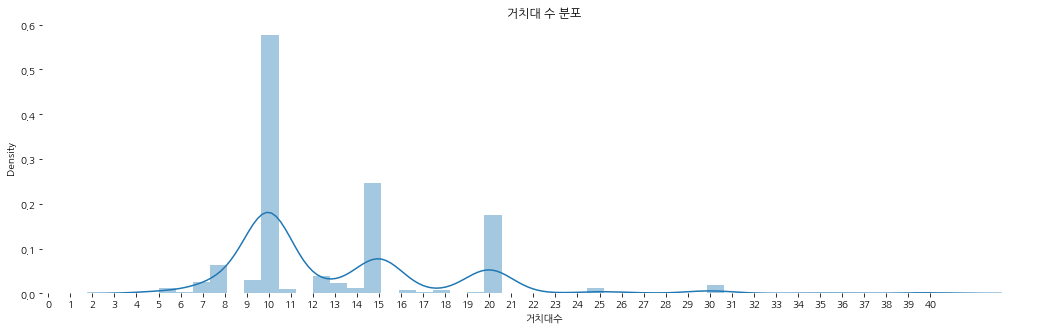

In [15]:
plt.figure(figsize=(18, 5))
sns.distplot(rental['거치대수'])
plt.title("거치대 수 분포")
plt.xticks(range(0, 41))
plt.box(False)
plt.show()

- 일반적으로 10개, 조금 더 많은 곳은 15개, 20~21개


## - 지역별 대여소당 평균 거치대 수

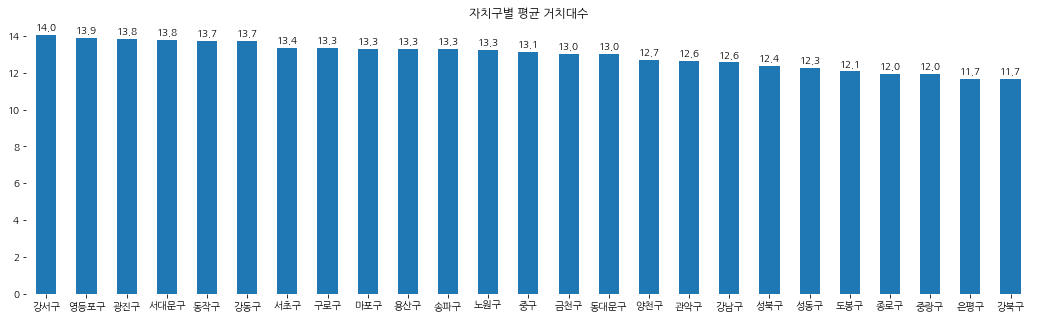

In [16]:
bike_rental = rental.groupby('자치구')['거치대수'].sum()
bike_rental = bike_rental / have_bikes
bike_rental.sort_values(ascending=False, inplace=True)

ax = bike_rental.plot(kind='bar', figsize=(18, 5), rot=0, title="자치구별 평균 거치대수")
for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%.1f"%(height), (left+width/2, height+0.3), ha='center')
plt.box(False)
plt.xlabel("")
plt.show()

- 지역별 평균 거치대 수는 11~14대 사이


In [17]:
bike_map = folium.Map(location=[rental['위도'].mean(), rental['경도'].mean()], zoom_start=10.8, tiles='cartodbpositron')
folium.Choropleth(geo_data=geo_str,
                  data=bike_rental,
                  key_on='feature.properties.SIG_KOR_NM', 
                  fill_color='Blues').add_to(bike_map)
bike_map

- 색이 진할 수록 값이 크다.


## - 가장 가까운 대여소 간 평균 거리

In [18]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    m = 1000 * km
    return m

In [19]:
dict_dists = {}
for name, df in rental.groupby('자치구'):
    dists = []
    for i, i_row in df.iterrows():
        min_dist = float('INF')
        
        for j, j_row in df.iterrows():
            if i == j:
                continue
            distance = haversine(i_row['경도'], i_row['위도'], j_row['경도'], j_row['위도'])       
            min_dist = distance if distance < min_dist else min_dist
                
        dists.append(min_dist)
    dict_dists[name] = dists

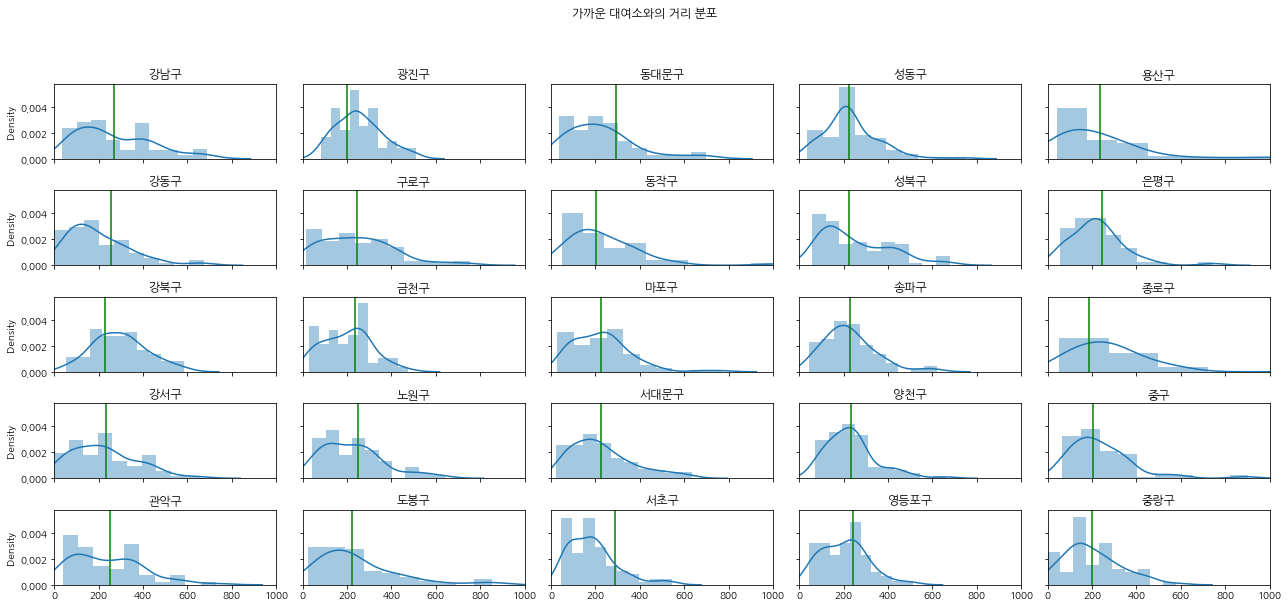

In [20]:
fig, axes = plt.subplots(5, 5, figsize=(18, 8), sharex=True, sharey=True)

i, j = 0, 0
for name, dists in dict_dists.items():
    sns.distplot(dists, ax=axes[i][j], bins=10)
    axes[j][i].set_title(name)
    axes[j][i].axvline(np.array(dists).mean(), color='green')
    j += 1
    if j >= 5:
        i += 1
        j = 0

fig.suptitle("가까운 대여소와의 거리 분포", y=1.05)
plt.xlim(0, 1000)
fig.tight_layout()
plt.show()

- 초록색 선 : 해당 지역의 평균 값(평균 거리)
- 가장 가까운 대여소 간의 거리 : 200 ~ 400m 안


### 특정 구의 대여소 분포를 지도에서 살펴보기

In [21]:
Gwanak = rental[rental['자치구'] == '관악구']

bike_map = folium.Map(location=[Gwanak['위도'].mean(), Gwanak['경도'].mean()], zoom_start=14)
for i, row in Gwanak.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=5,
        fill=True,
    ).add_to(bike_map)
bike_map

plugins.HeatMap(Gwanak[['위도', '경도']].values.tolist()).add_to(bike_map)
bike_map

## 지역별로 가까운 대여소 평균 거리

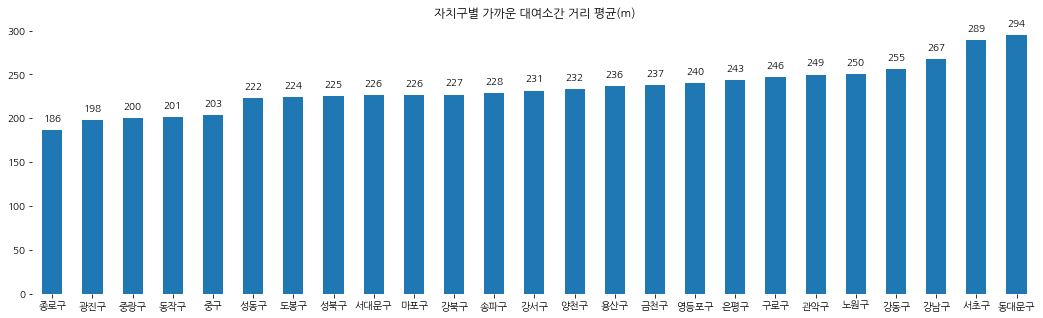

In [22]:
dist_means = {name: np.mean(dists) for name, dists in dict_dists.items() }
dist_means = pd.Series(dist_means)
dist_means.sort_values(inplace=True)

ax = dist_means.plot(kind='bar', figsize=(18, 5), rot=0, legend=False, title="자치구별 가까운 대여소간 거리 평균(m)")
for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%d"%(height), (left+width/2, height+10), ha='center')
plt.box(False)
plt.show()

- 지역별 대여소 간 평균 거리는 186~294m 안쪽


In [23]:
bike_map = folium.Map(location=[rental['위도'].mean(),rental['경도'].mean()],zoom_start=10.8,tiles='cartodbpositron')
folium.Choropleth(geo_data=geo_str, data=dist_means, key_on='feature.properties.SIG_KOR_NM', fill_color='Blues').add_to(bike_map)
bike_map